# Gesture Recognition
    - By Mahalakshmi Totad

#### Problem Statement
Develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

### Understanding the Dataset
The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images).

Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos.

Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from skimage.io import imread
from cv2 import resize
import datetime
import os

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D ,  Conv2D, MaxPooling2D , LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
from keras.layers import Dropout
import tensorflow as tf
# tf.set_random_seed(30)

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [6]:
# train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Colab Notebooks/GestureRecognition/train.csv').readlines())
# val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Colab Notebooks/GestureRecognition//val.csv').readlines())

train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())

#### Pre-processing on image
		number of images to be taken per video/sequence
		cropping the images
		resizing the images
		normalizing the images
		keeping the aspect ratio of all the images the same

- Overfit on small amount of data and train the model
- Decide batch size


### Generic Reusable Functions

In [9]:
def print_accuracy_loss_values(model,history,num_epochs):
  print("Total Params:", model.count_params())

  plt.figure(figsize = (10,10))

  acc = history.history['categorical_accuracy']
  val_acc = history.history['val_categorical_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(num_epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [10]:
#constants
curr_dt_time = datetime.datetime.now()

# train_path = '/content/gdrive/MyDrive/Colab Notebooks/GestureRecognition/train'
# val_path = '/content/gdrive/MyDrive/Colab Notebooks/GestureRecognition/val'

train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'


num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

imageheight = 120
imagewidth = 120
num_of_channels = 3
num_of_classes = 5
num_frames = 30


# training sequences = 663
# validation sequences = 100


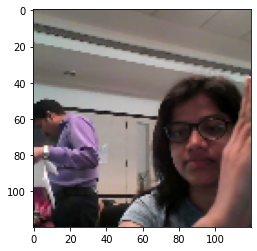

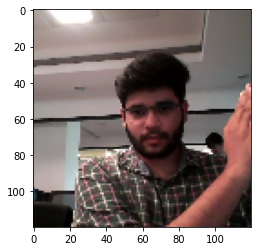

In [12]:
## Image transformation sample
#360 by 360
image1 = imread("datasets/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00014.png")
#160 by 120
image2 = imread("datasets/Project_data/train/WIN_20180907_15_38_24_Pro_Right Swipe_new/WIN_20180907_15_38_24_Pro_00013.png")
#crop the images and resize them. Note that the images are of 2 different shape
#and the conv3D will throw error if the inputs in a batch have different shapes
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120))
# image1 = datagen.random_transform(image1)
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120))
# image2 = datagen.random_transform(image2)
plt.imshow(image2)
plt.show()


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [13]:
def generator(source_path, folder_list, batch_size,frames_to_sample):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    #create a list of image numbers you want to use for a particular video
    # img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
    # img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    img_idx = np.round(np.linspace(0,num_frames-1,frames_to_sample)).astype(int)

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size# calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames_to_sample,imageheight,imagewidth,num_of_channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in

                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # image_resized=image_transformation(image)
                    image_resized = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,0])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        num_remainder_batches = len(folder_list)%batch_size

        if num_remainder_batches !=0 :
            batch_data = np.zeros((num_remainder_batches,frames_to_sample,imageheight,imagewidth,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((num_remainder_batches,5))
            for folder in range(num_remainder_batches): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image_resized = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,0])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Convo3D Models

### Model 1

In [13]:
num_epochs = 3 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 50  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 18
print ('# frames_to_sample per video =', frames_to_sample)

# epochs = 3
# batch size = 50
# frames_to_sample per video = 18


In [20]:
#write your model here
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
# learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
learning_rate = 0.001
optimiser = tf.optimizers.Adam(learning_rate)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 60, 60, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 9, 60, 60, 32)    

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [21]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [23]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# epoch_steps, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Source path =  datasets/Project_data/train ; batch size = 50
Epoch 1/3


2024-01-29 14:55:37.231496: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


14/14 [==============================] - ETA: 0s - loss: 1.4052 - categorical_accuracy: 0.4751Source path =  datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2024-01-2914_53_23.587929/model-00001-1.40524-0.47511-1.84867-0.23000.h5
14/14 [==============================] - 53s 4s/step - loss: 1.4052 - categorical_accuracy: 0.4751 - val_loss: 1.8487 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/3
14/14 [==============================] - ETA: 0s - loss: 0.6112 - categorical_accuracy: 0.7994
Epoch 00002: saving model to model_init_2024-01-2914_53_23.587929/model-00002-0.61119-0.79940-2.64691-0.25000.h5
14/14 [==============================] - 41s 3s/step - loss: 0.6112 - categorical_accuracy: 0.7994 - val_loss: 2.6469 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/3
14/14 [==============================] - ETA: 0s - loss: 0.3330 - categorical_accuracy: 0.9080
Epoch 00003: saving model to model_init_2024-01-2914_53_23.587929/model-00003-

<Figure size 720x720 with 0 Axes>

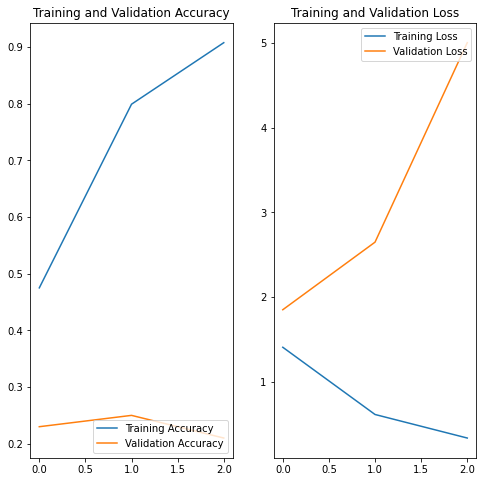

In [24]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

### Inference : Model 1 is working, all the steps seem to be ok. Now lets run it for 20 epochs

### Model 2

In [33]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 30  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 20
print ('# frames_to_sample per video =', frames_to_sample)

# epochs = 20
# batch size = 30
# frames_to_sample per video = 20


In [34]:
#write your model here
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels))) #frames ,imageheight, imagewidth, no of channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_4 (Bat  (None, 20, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 10, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 60, 60, 32)   

In [35]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [36]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# steps_per_epoch, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

In [38]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

Source path =  Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.3629 - categorical_accuracy: 0.4842Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2024-01-2912_41_35.149777/model-00001-1.36286-0.48416-1.62821-0.34000.h5
23/23 [==============================] - 144s 6s/step - loss: 1.3629 - categorical_accuracy: 0.4842 - val_loss: 1.6282 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 0.8150 - categorical_accuracy: 0.6772
Epoch 2: saving model to model_init_2024-01-2912_41_35.149777/model-00002-0.81503-0.67722-11.07833-0.18000.h5
23/23 [==============================] - 142s 6s/step - loss: 0.8150 - categorical_accuracy: 0.6772 - val_loss: 11.0783 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.5832 - categorical_accuracy: 0.8009
Epoch 3: saving model to m

TypeError: print_accuracy_loss_values() missing 3 required positional arguments: 'model', 'history', and 'num_epochs'

Total Params: 1866181


<Figure size 1000x1000 with 0 Axes>

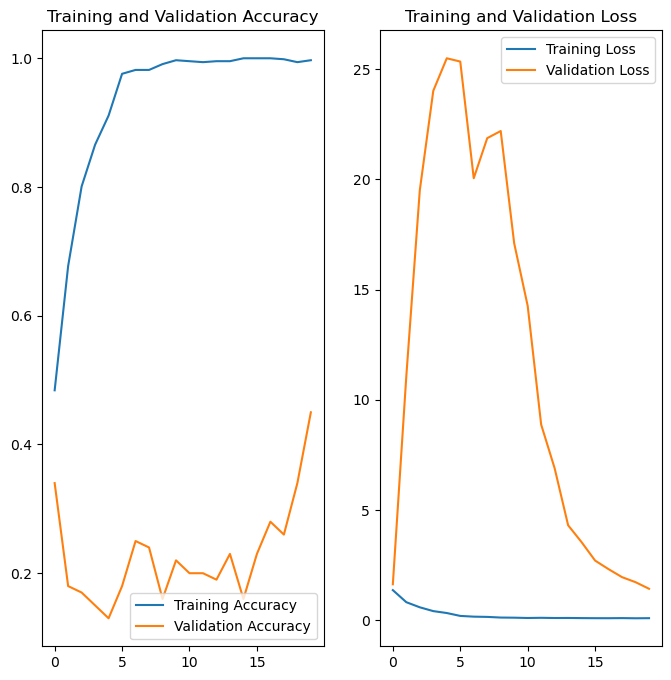

In [39]:
print_accuracy_loss_values(model,history,num_epochs)

### Inference Model 2 : 
    - Total params: 1866181
    - categorical_loss: 0.0902 
    - categorical_accuracy: 0.9970 
    - val_loss: 1.4247 
    - val_categorical_accuracy: 0.4500
- Traning accuracy is high where as validation accuracy is very low. Model seems to be highly overfitting.
- Validation loss has reduced as number of epochs have increased indicating good sign of learning by the model.
- Let's take some steps to reduce overfitting and get better results

    

### Model 3
- Adding one more Convo3D layer and a Dense layer
- Running for 40 epochs

In [40]:
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 30  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 20
print ('# frames_to_sample per video =', frames_to_sample)

# epochs = 40
# batch size = 30
# frames_to_sample per video = 20


In [41]:
#write your model here
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels))) #frames ,imageheight, imagewidth, no of channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_6 (Activation)   (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_8 (Bat  (None, 20, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 10, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 10, 60, 60, 32)   

In [42]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [43]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [44]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# steps_per_epoch, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.1683 - categorical_accuracy: 0.5490
Epoch 1: saving model to model_init_2024-01-2912_41_35.149777/model-00001-1.16825-0.54902-8.71658-0.17000.h5
23/23 [==============================] - 150s 7s/step - loss: 1.1683 - categorical_accuracy: 0.5490 - val_loss: 8.7166 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 0.9711 - categorical_accuracy: 0.6078
Epoch 2: saving model to model_init_2024-01-2912_41_35.149777/model-00002-0.97115-0.60784-9.80760-0.25000.h5
23/23 [==============================] - 148s 6s/step - loss: 0.9711 - categorical_accuracy: 0.6078 - val_loss: 9.8076 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 0.8344 - categorical_accuracy: 0.6893
Epoch 3: saving model to model_init_2024-01-2912_41_35.149777/model-00003-0.83443-0.68929-10.85124-0.20000.h5
23/23 [=============

<Figure size 1000x1000 with 0 Axes>

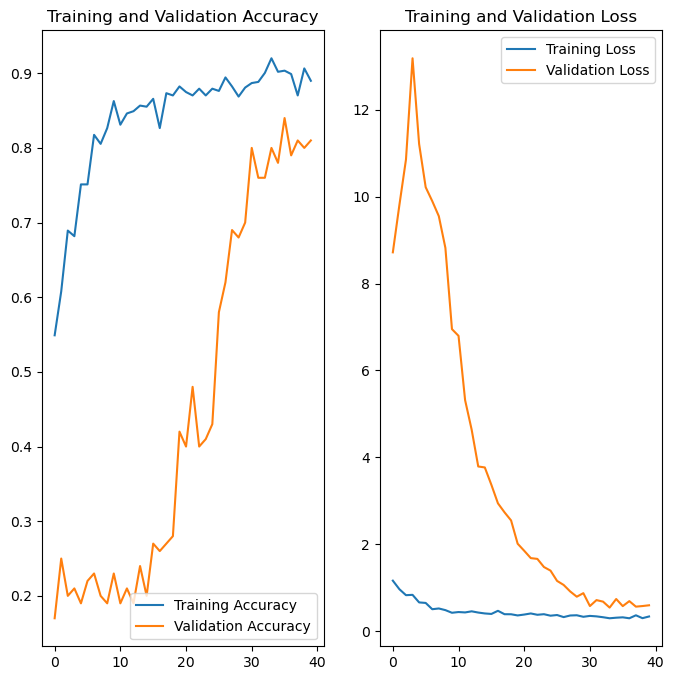

In [47]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

### Inference Model 3 : 
- Adding a layers seems to have improved the accuracy
- Model seems to have learnt more with  increased number of epochs.
 
     - Total Params: 900805
     - categorical_loss: 0.3445 
     - categorical_accuracy: 0.8899 
     - val_loss: 0.6020 
     - val_categorical_accuracy: 0.8100 

### Model 4
- Change filtersr to 8,32,64 and remove 128f layer
- Reducing the total number of parameters
- Running for 40 epochs
- batch size of 20
- frames per video of 15

In [25]:
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 15
print ('# frames_to_sample per video =', frames_to_sample)

# epochs = 40
# batch size = 20
# frames_to_sample per video = 15


In [26]:
#write your model here
model = Sequential()
model.add(Conv3D(8, (2, 2, 2), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels))) #frames ,imageheight, imagewidth, no of channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
# model.add(Dense(128,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 15, 120, 120, 8)   656       
                                                                 
 activation_15 (Activation)  (None, 15, 120, 120, 8)   0         
                                                                 
 batch_normalization_20 (Bat  (None, 15, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 7, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 7, 60, 60, 32)     2080      
                                                                 
 activation_16 (Activation)  (None, 7, 60, 60, 32)    

In [28]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# steps_per_epoch, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.3005 - categorical_accuracy: 0.4766Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-01-2914_53_23.587929/model-00001-1.30050-0.47662-1.99245-0.24000.h5
34/34 [==============================] - 43s 1s/step - loss: 1.3005 - categorical_accuracy: 0.4766 - val_loss: 1.9924 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 0.7325 - categorical_accuracy: 0.7587
Epoch 00002: saving model to model_init_2024-01-2914_53_23.587929/model-00002-0.73245-0.75867-4.25738-0.24000.h5
34/34 [==============================] - 34s 1s/step - loss: 0.7325 - categorical_accuracy: 0.7587 - val_loss: 4.2574 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 0.4730 - categorical_accuracy: 0.8824
Epoc

<Figure size 720x720 with 0 Axes>

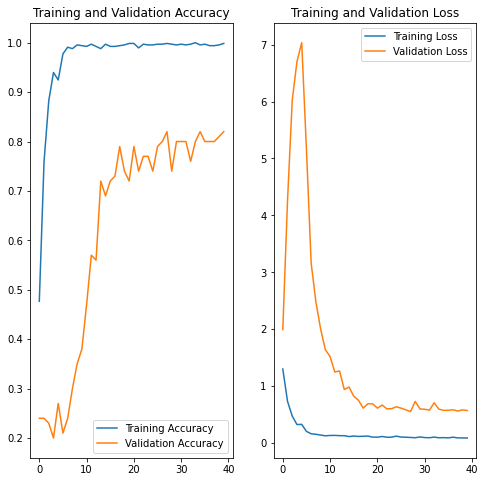

In [31]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

### Inference Model 4 : 
- Change filters to 8,32,64 and remove 128f layer
- Reducing the total number of parameters
  
     - Total Params: 480,725
     - categorical_loss:  0.0879
     - categorical_accuracy:  0.9985
     - val_loss:  0.5717
     - val_categorical_accuracy:   0.8200
     
- Validation loss is less by 0.03 and acuracy is more by 0.01 than Model 3 which is a good sign for the model, but categorical_accuracy is 0.9985 to val_categorical_accuracy of 0.82. Thus indicating that Model is overfitting with less number of parameters

### Model 5
- Model 3 with below hyperparams
- Running for 40 epochs
- batch size of 20
- Increasing frames per video to 30

In [32]:
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 30
print ('# frames_to_sample per video =', frames_to_sample)

# epochs = 40
# batch size = 20
# frames_to_sample per video = 30


In [33]:
#write your model here
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels))) #frames ,imageheight, imagewidth, no of channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_18 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_19 (Activation)  (None, 15, 60, 60, 32)   

In [35]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [36]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# steps_per_epoch, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.4752 - categorical_accuracy: 0.4434Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-01-2914_53_23.587929/model-00001-1.47517-0.44344-2.49284-0.16000.h5
34/34 [==============================] - 79s 2s/step - loss: 1.4752 - categorical_accuracy: 0.4434 - val_loss: 2.4928 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.0779 - categorical_accuracy: 0.5641
Epoch 00002: saving model to model_init_2024-01-2914_53_23.587929/model-00002-1.07792-0.56410-2.94068-0.17000.h5
34/34 [==============================] - 70s 2s/step - loss: 1.0779 - categorical_accuracy: 0.5641 - val_loss: 2.9407 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 0.9653 - categorical_accuracy: 0.6199
Epoc

<Figure size 720x720 with 0 Axes>

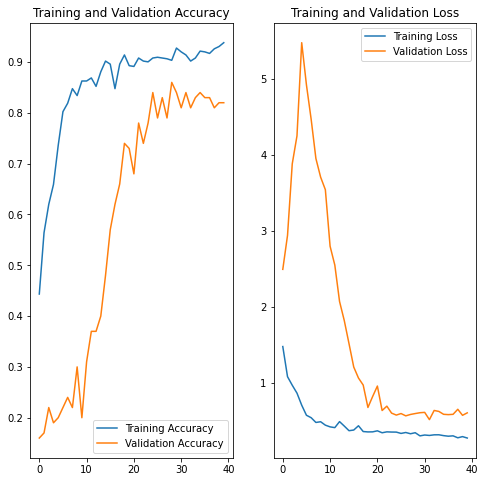

In [38]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

### Inference Model 5 : 
- Model 3 layers with below hyperparams
- Running for 40 epochs, batch size of 20 and frames per video of 30
     - Total Params: 896,389
     - categorical_loss:  0.2692
     - categorical_accuracy:   0.9382
     - val_loss:   0.6012
     - val_categorical_accuracy:  0.8200
     
- Increasing number of frames per video 
    - has increased the training accuracy from 0.88 to 0.93
    - has increased the validation  accuracy from 0.81 to 0.82
    - has reduced the validation loss from 0.6020 to 0.6012
    
Not a significant improvement interms of validations results. Let's change try a different model

### Model 6
- Model 3 with below hyperparams
- Running for 40 epochs
- batch size of 20
- Increasing frames per video to 30 
- Dropout 0.25
- adding dense layer with 256 
- filter (3,3,3)

In [53]:
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 30
print ('# frames_to_sample per video =', frames_to_sample)

# epochs = 40
# batch size = 20
# frames_to_sample per video = 30


In [54]:
#write your model here
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels))) #frames ,imageheight, imagewidth, no of channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_22 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_38 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_23 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_23 (Activation)  (None, 15, 60, 60, 32)   

In [55]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [56]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [57]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# steps_per_epoch, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.5565 - categorical_accuracy: 0.4434Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-01-2914_53_23.587929/model-00001-1.55651-0.44344-1.74189-0.29000.h5
34/34 [==============================] - 73s 2s/step - loss: 1.5565 - categorical_accuracy: 0.4434 - val_loss: 1.7419 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.0410 - categorical_accuracy: 0.5943
Epoch 00002: saving model to model_init_2024-01-2914_53_23.587929/model-00002-1.04101-0.59427-2.50523-0.18000.h5
34/34 [==============================] - 69s 2s/step - loss: 1.0410 - categorical_accuracy: 0.5943 - val_loss: 2.5052 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/40
33/34 [============================>.] - ETA: 1s - loss: 0.8902 - categorical_accuracy: 0.6788
Epoc

<Figure size 720x720 with 0 Axes>

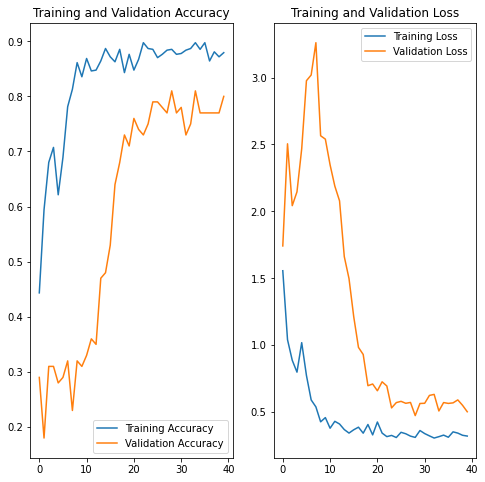

In [58]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

### Inference : Model 6
- with Dropoutto 0.25 , adding dense layer with 256 and filter (3,3,3)
     - Total Params: 1,131,589
     - categorical_loss:   0.3209 
     - categorical_accuracy:  0.8793
     - val_loss:  0.5026
     - val_categorical_accuracy: 0.8000 
       


### Model 7

In [81]:
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 20
print ('# frames_to_sample per video =', frames_to_sample)

# epochs = 40
# batch size = 20
# frames_to_sample per video = 20


In [82]:
#write your model here
model = Sequential()
model.add(Conv3D(16, (2,2,2), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels))) #frames ,imageheight, imagewidth, no of channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_26 (Conv3D)          (None, 20, 120, 120, 16)  400       
                                                                 
 activation_26 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_47 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_27 (Conv3D)          (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_27 (Activation)  (None, 10, 60, 60, 32)  

In [83]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [84]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [85]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# steps_per_epoch, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 2.0659 - categorical_accuracy: 0.3002Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-01-2914_53_23.587929/model-00001-2.06591-0.30015-1.83689-0.19000.h5
34/34 [==============================] - 53s 2s/step - loss: 2.0659 - categorical_accuracy: 0.3002 - val_loss: 1.8369 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/40
33/34 [============================>.] - ETA: 1s - loss: 1.5530 - categorical_accuracy: 0.4303
Epoch 00002: saving model to model_init_2024-01-2914_53_23.587929/model-00002-1.55551-0.42986-2.03779-0.21000.h5
34/34 [==============================] - 47s 1s/step - loss: 1.5555 - categorical_accuracy: 0.4299 - val_loss: 2.0378 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.4893 - categorical_accuracy: 0.4389
Epoc

<Figure size 720x720 with 0 Axes>

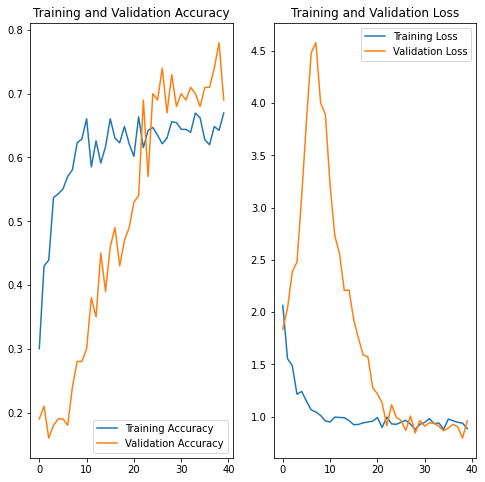

In [86]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

### Inference : Model 7
     - Total Params: 895477
     - categorical_loss:  0.8865  
     - categorical_accuracy:   0.6697
     - val_loss:  0.9613 
     - val_categorical_accuracy: 0.6900 
- Validation accuracy is more than training accuracy so adding dropouts to layers is reducing number of parameters at unaccceptable level. 

### Model 8 
- Seems to have same results - let's change and model layers

In [14]:
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 20
print ('# frames_to_sample per video =', frames_to_sample)

imageheight =120
imagewidth = 120

# epochs = 40
# batch size = 20
# frames_to_sample per video = 20


In [1]:
#write your model here
model = Sequential()
model.add(Conv3D(8, (3,3,3), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels))) #frames ,imageheight, imagewidth, no of channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (3,3,3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# model.add(Dense(128,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

NameError: name 'Sequential' is not defined

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# steps_per_epoch, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/40


2024-01-30 04:47:30.228008: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6120 - categorical_accuracy: 0.3665Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-01-3004_47_05.747776/model-00001-1.61204-0.36652-1.59214-0.33000.h5
34/34 [==============================] - 57s 2s/step - loss: 1.6120 - categorical_accuracy: 0.3665 - val_loss: 1.5921 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.1946 - categorical_accuracy: 0.5324
Epoch 00002: saving model to model_init_2024-01-3004_47_05.747776/model-00002-1.19456-0.53243-5.08082-0.22000.h5
34/34 [==============================] - 46s 1s/step - loss: 1.1946 - categorical_accuracy: 0.5324 - val_loss: 5.0808 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 0.9983 - categorical_accuracy: 0.6305
Epoch 00003: saving model to model_init_2024-01-3004_47_05.747776/model-0000

<Figure size 720x720 with 0 Axes>

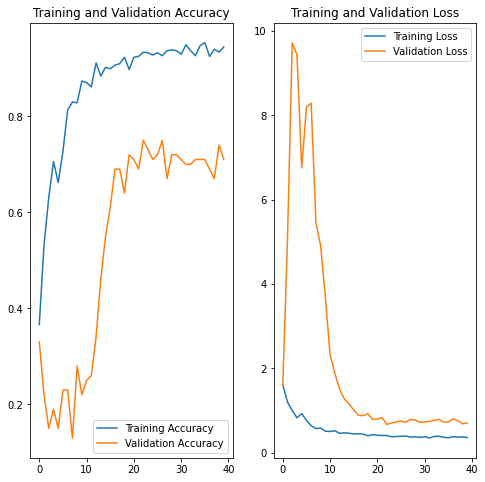

In [19]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

### Inference : Model 8
     - Total Params: 985301
     - categorical_loss: loss: 0.3568  
     - categorical_accuracy:  0.9442 
     - val_loss:  0.7019
     - val_categorical_accuracy:  0.7100
       
- Clearly we need those layers as validation loss has gone up to 0.7 and accurancy has reduce to 0.71

### Model 9 
- on top of Model 3/4

In [142]:
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 20
print ('# frames_to_sample per video =', frames_to_sample)

# epochs = 30
# batch size = 20
# frames_to_sample per video = 20


In [143]:
#write your model here
model = Sequential()
model.add(Conv3D(8, (2,2,2), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels))) #frames ,imageheight, imagewidth, no of channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_89 (Conv3D)          (None, 20, 120, 120, 8)   200       
                                                                 
 activation_89 (Activation)  (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_139 (Ba  (None, 20, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_89 (MaxPoolin  (None, 10, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_90 (Conv3D)          (None, 10, 60, 60, 32)    2080      
                                                                 
 activation_90 (Activation)  (None, 10, 60, 60, 32)  

In [144]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [145]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [146]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# steps_per_epoch, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.7028 - categorical_accuracy: 0.4103Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-01-2914_53_23.587929/model-00001-1.70275-0.41026-2.93512-0.16000.h5
34/34 [==============================] - 49s 1s/step - loss: 1.7028 - categorical_accuracy: 0.4103 - val_loss: 2.9351 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.1824 - categorical_accuracy: 0.5520
Epoch 00002: saving model to model_init_2024-01-2914_53_23.587929/model-00002-1.18239-0.55204-12.77933-0.13000.h5
34/34 [==============================] - 45s 1s/step - loss: 1.1824 - categorical_accuracy: 0.5520 - val_loss: 12.7793 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9170 - categorical_accuracy: 0.6456
Ep

<Figure size 720x720 with 0 Axes>

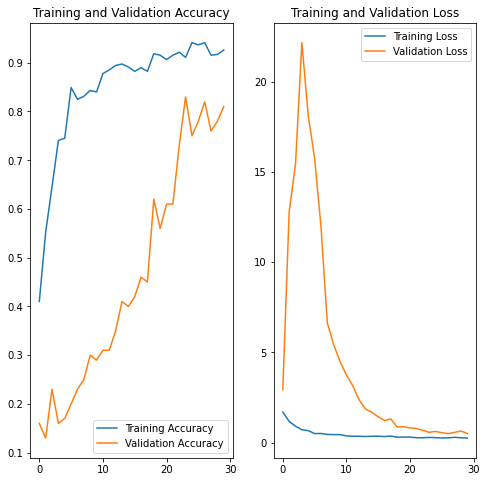

In [147]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

### Inference : Model 9
     - Total Params:  3710605
     - categorical_loss:   0.2617
     - categorical_accuracy:   0.9261 
     - val_loss:   0.5138
     - val_categorical_accuracy:  0.8100 

- Number of parameters is 37,10,605 which is a lot more than model 3 and 5
- But there is significant improvemnt in validation loss and accuracy

### Model 10

In [22]:
num_epochs = 35 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 30
print ('# frames_to_sample per video =', frames_to_sample)

# epochs = 35
# batch size = 20
# frames_to_sample per video = 30


In [28]:
#write your model here
model = Sequential()
model.add(Conv3D(16, (2, 2, 2), padding='same',
                 input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels))) #frames ,imageheight, imagewidth, no of channels
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_of_classes,activation='softmax'))

#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_34 (Conv3D)          (None, 30, 120, 120, 16)  400       
                                                                 
 activation_34 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_41 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_35 (Conv3D)          (None, 30, 120, 120, 32)  4128      
                                                                 
 activation_35 (Activation)  (None, 30, 120, 120, 32)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 30, 120, 120, 32)  128      
 chNormalization)                                     

In [29]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [31]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

# callback_list = callback_list()

# steps_per_epoch, validation_steps = epoch_steps(num_train_sequences, num_val_sequences, batch_size)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/35
34/34 [==============================] - ETA: 0s - loss: 1.5278 - categorical_accuracy: 0.4057Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-01-3004_47_05.747776/model-00001-1.52781-0.40573-3.91392-0.21000.h5
34/34 [==============================] - 85s 2s/step - loss: 1.5278 - categorical_accuracy: 0.4057 - val_loss: 3.9139 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/35
34/34 [==============================] - ETA: 0s - loss: 1.1360 - categorical_accuracy: 0.5309
Epoch 00002: saving model to model_init_2024-01-3004_47_05.747776/model-00002-1.13595-0.53092-6.41882-0.19000.h5
34/34 [==============================] - 80s 2s/step - loss: 1.1360 - categorical_accuracy: 0.5309 - val_loss: 6.4188 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/35
34/34 [==============================] - ETA: 0s - loss: 1.0607 - categorical_accuracy: 0.5747
Epoc

<Figure size 720x720 with 0 Axes>

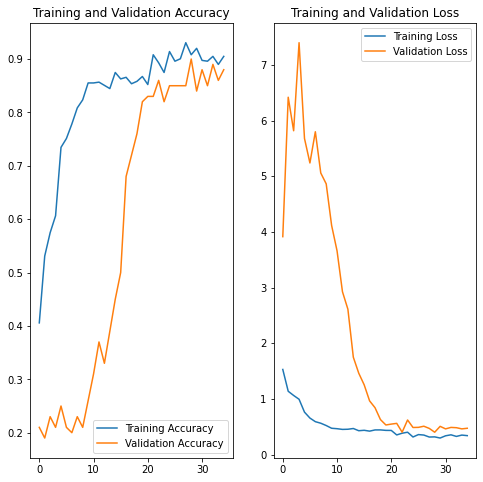

In [32]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(model,history,num_epochs)

### Inference : Model 10
     - Total Params: 1961717
     - categorical_loss:  0.3390 
     - categorical_accuracy:   0.9050
     - val_loss:   0.4714
     - val_categorical_accuracy: : 0.8800

Epoch 29 giving the best results so far
- loss: 0.3166 
- categorical_accuracy: 0.9080 
- val_loss: 0.4002 
- val_categorical_accuracy: 0.9000


### Conv3D All models summaries

#### Conv3D Models
1. model 1 -test model

2. model 2- - Total params: 1866181
    - categorical_loss: 0.0902 
    - categorical_accuracy: 0.9970 
    - val_loss: 1.4247 
    - val_categorical_accuracy: 0.4500

3. model 3 - Total Params: 900805
     - categorical_loss: 0.3445 
     - categorical_accuracy: 0.8899 
     - val_loss: 0.6020 
     - val_categorical_accuracy: 0.8100 
     
4. model 4 - Total Params: 480,725
 - categorical_loss:  0.0879
 - categorical_accuracy:  0.9985
 - val_loss:  0.5717
 - val_categorical_accuracy:   0.8200 
     
5. model 5 -Total Params: 896,389
    - categorical_loss: 0.2692
    - categorical_accuracy: 0.9382
    - val_loss: 0.6012
    - val_categorical_accuracy: 0.8200
    
6. model 6 - Total Params: 1,131,589
     - categorical_loss:   0.3209 
     - categorical_accuracy:  0.8793
     - val_loss:  0.5026
     - val_categorical_accuracy: 0.8000 
     
7. model 7 - Total Params: 895477
    - categorical_loss:  0.8865  
     - categorical_accuracy:   0.6697
    - val_loss:  0.9613 
    - val_categorical_accuracy: 0.6900 
    
8. model 8 - Total Params: 985301
      - categorical_loss: loss: 0.3568  
      - categorical_accuracy:  0.9442 
      - val_loss:  0.7019
    - val_categorical_accuracy:  0.7100
    
9. model 9 - Total Params:  3710605
    - categorical_loss:   0.2617
    - categorical_accuracy:   0.9261 
     - val_loss:   0.5138
     - val_categorical_accuracy:  0.8100 
     
10. model 10 -  Total Params: 1961717
    - categorical_loss:  0.3390 
     - categorical_accuracy:   0.9050
     - val_loss:   0.4714
     - val_categorical_accuracy: : 0.8800
     

### CNN + RNN Architecture

### Model 1 : 
- CNN 2D with LSTM ( 64cells)

In [41]:
#parameters
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 20
print ('# frames_to_sample per video =', frames_to_sample)

dropout = 0.25
print ('# dropout  =', dropout)

lstm_cells = 64
print ('# Number of lstm_cells  =', lstm_cells)

# epochs = 40
# batch size = 20
# frames_to_sample per video = 20
# dropout  = 0.25
# Number of lstm_cells  = 64


In [42]:
#pass the images of a video through a CNN(COnvo2D) which extracts a feature vector for each image
cnn_rnn_model = Sequential()

cnn_rnn_model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels)))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

# cnn_rnn_model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
# cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
# cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

#cnn_rnn_model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
# cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
# cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_model.add(TimeDistributed(Flatten()))

# pass the sequence of these feature vectors through an RNN
cnn_rnn_model.add(LSTM(lstm_cells))
cnn_rnn_model.add(Dropout(dropout))

cnn_rnn_model.add(Dense(128,activation='relu'))
cnn_rnn_model.add(Dropout(dropout))

cnn_rnn_model.add(Dense(num_of_classes, activation='softmax'))

#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

cnn_rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn_model.summary())



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 60, 60, 32)  

In [43]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [44]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [45]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.5759 - categorical_accuracy: 0.2971Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-01-2914_53_23.587929/model-00001-1.57591-0.29713-1.66711-0.18000.h5
34/34 [==============================] - 60s 2s/step - loss: 1.5759 - categorical_accuracy: 0.2971 - val_loss: 1.6671 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/40
34/34 [==============================] - ETA: 0s - loss: 1.3919 - categorical_accuracy: 0.4284
Epoch 00002: saving model to model_init_2024-01-2914_53_23.587929/model-00002-1.39189-0.42836-1.64666-0.19000.h5
34/34 [==============================] - 47s 1s/step - loss: 1.3919 - categorical_accuracy: 0.4284 - val_loss: 1.6467 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/40
34/34 [==============================] - ETA: 0s - loss: 1.2551 - categorical_accuracy: 0.4842
Epoc

<Figure size 720x720 with 0 Axes>

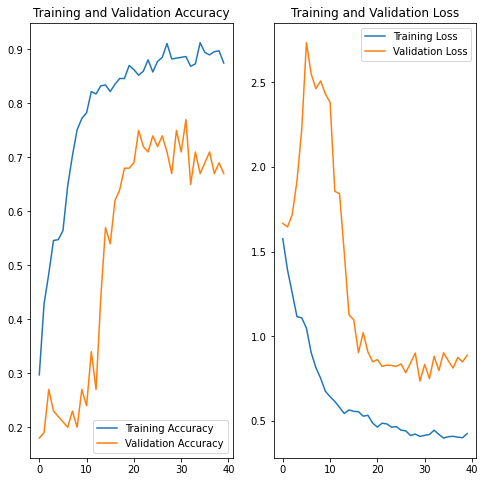

In [46]:
history = cnn_rnn_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(cnn_rnn_model,history,num_epochs)

### Inference :CNN+RNN (LSTM)  Model 1 
- CNN with RNN (LSTM - 64cells)
     - Total Params: 1,729,637
     - categorical_loss:  0.4255
     - categorical_accuracy:  0.8748
     - val_loss:  0.8886
     - val_categorical_accuracy:   0.6700

- Looking at the accuracies and loss Convo3D models had better learning and accuracy.

### Model 2 : 
- CNN 2D with GRU ( 128cells)

In [48]:
cells = 128
print ('# Number of gru_cells  =',cells)

#pass the images of a video through a CNN(COnvo2D) which extracts a feature vector for each image
cnn_rnn_model = Sequential()

cnn_rnn_model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels)))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))

cnn_rnn_model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
cnn_rnn_model.add(TimeDistributed(BatchNormalization()))
cnn_rnn_model.add(TimeDistributed(MaxPooling2D((2, 2))))
cnn_rnn_model.add(TimeDistributed(Flatten()))

# pass the sequence of these feature vectors through an RNN
cnn_rnn_model.add(GRU(cells))
cnn_rnn_model.add(Dropout(dropout))

cnn_rnn_model.add(Dense(128,activation='relu'))
cnn_rnn_model.add(Dropout(dropout))

cnn_rnn_model.add(Dense(num_of_classes, activation='softmax'))

#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

cnn_rnn_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn_rnn_model.summary())



# Number of gru_cells  = 128
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (Tim

In [49]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [50]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [51]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/40
34/34 [==============================] - ETA: 0s - loss: 1.4347 - categorical_accuracy: 0.3876Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-01-2914_53_23.587929/model-00001-1.43473-0.38763-2.22477-0.29000.h5
34/34 [==============================] - 58s 2s/step - loss: 1.4347 - categorical_accuracy: 0.3876 - val_loss: 2.2248 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/40
33/34 [============================>.] - ETA: 1s - loss: 1.2093 - categorical_accuracy: 0.5030
Epoch 00002: saving model to model_init_2024-01-2914_53_23.587929/model-00002-1.20752-0.50377-1.92125-0.26000.h5
34/34 [==============================] - 46s 1s/step - loss: 1.2075 - categorical_accuracy: 0.5038 - val_loss: 1.9213 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/40
33/34 [============================>.] - ETA: 1s - loss: 1.0545 - categorical_accuracy: 0.5621
Epoc

<Figure size 720x720 with 0 Axes>

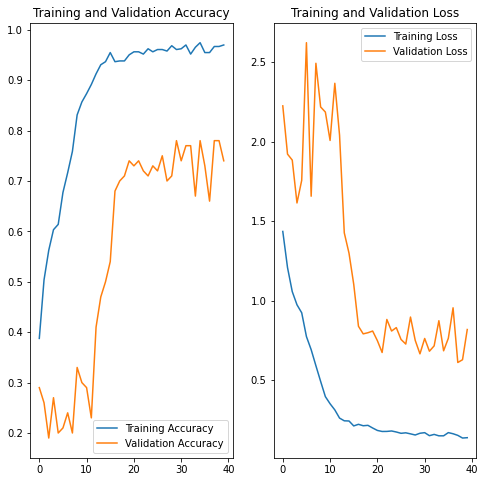

In [52]:
history = cnn_rnn_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(cnn_rnn_model,history,num_epochs)

### Inference : Model 2 CNN+RNN (GRU)
- CNN with RNN (GRU - 128 cells)
     - Total Params: 2,573,925
     - categorical_loss:  0.1371
     - categorical_accuracy:  0.9698
     - val_loss:  0.8177
     - val_categorical_accuracy:  0.7400 
       


### Transfer Learning

### Model 1 - Using  Mobilenet + LSTM

In [61]:
from keras.applications import mobilenet

In [62]:
#parameters

num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 5  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 20
print ('# frames_to_sample per video =', frames_to_sample)

lstm_cells=128

dense_layer=128

dropout=0.25

# epochs = 20
# batch size = 5
# frames_to_sample per video = 20


In [63]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

            
tl_model = Sequential()
tl_model.add(TimeDistributed(mobilenet_transfer,input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels)))

#Not training mobilenet layers
for layer in tl_model.layers:
    layer.trainable = False

#pooling the mobilenet learning
tl_model.add(TimeDistributed(BatchNormalization()))
tl_model.add(TimeDistributed(MaxPooling2D((2, 2))))
tl_model.add(TimeDistributed(Flatten()))

#adding RNN layer
tl_model.add(LSTM(lstm_cells))
tl_model.add(Dropout(dropout))

tl_model.add(Dense(dense_layer,activation='relu'))
tl_model.add(Dropout(dropout))

tl_model.add(Dense(num_of_classes, activation='softmax'))


#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

tl_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (tl_model.summary())


17235968/17225924 [==============================] - 2s 0us/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                      

In [64]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [66]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

Source path =  datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4962 - categorical_accuracy: 0.3288Source path =  datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model_init_2024-01-2914_53_23.587929/model-00001-1.49622-0.32881-1.10800-0.57000.h5
133/133 [==============================] - 64s 461ms/step - loss: 1.4962 - categorical_accuracy: 0.3288 - val_loss: 1.1080 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 1.0820 - categorical_accuracy: 0.5596
Epoch 00002: saving model to model_init_2024-01-2914_53_23.587929/model-00002-1.08201-0.55958-1.12815-0.59000.h5
133/133 [==============================] - 48s 366ms/step - loss: 1.0820 - categorical_accuracy: 0.5596 - val_loss: 1.1282 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.7805 - categorical_accurac

<Figure size 720x720 with 0 Axes>

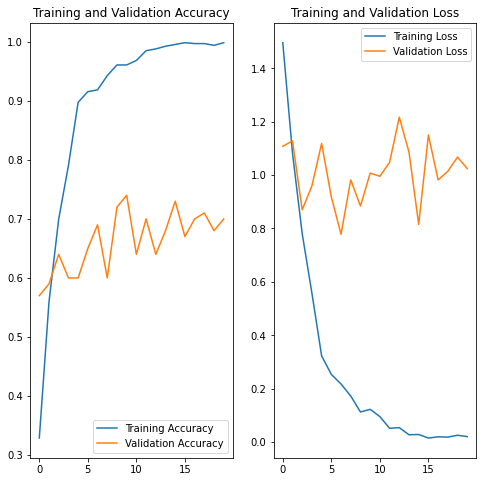

In [67]:
history = tl_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(tl_model,history,num_epochs)

### Inference :  Model 1 - Using  Mobilenet + LSTM
- CNN with RNN (LSTM - 128 cells)
     - Total Params: 3840453
     - categorical_loss: 0.0201 
     - categorical_accuracy:  0.9985 
     - val_loss: 1.0242 
     - val_categorical_accuracy:  0.7000
     
- Validation loss is very high. Model doesn't seem to learn with the architecture being used

### Model 2 - Using Mobilenet + GRU

In [33]:
from keras.applications import mobilenet

In [34]:
#parameters

num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 30  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 20
print ('# frames_to_sample per video =', frames_to_sample)

gru_cells=64

dense_layer=64

dropout=0.25

# epochs = 20
# batch size = 30
# frames_to_sample per video = 20


In [35]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

            
tl_model = Sequential()
tl_model.add(TimeDistributed(mobilenet_transfer,input_shape=(frames_to_sample,imageheight,imagewidth,num_of_channels)))

#Not training mobilenet layers
for layer in tl_model.layers:
    layer.trainable = False

#pooling the mobilenet learning
tl_model.add(TimeDistributed(BatchNormalization()))
tl_model.add(TimeDistributed(MaxPooling2D((2, 2))))
tl_model.add(TimeDistributed(Flatten()))

#adding RNN layer
tl_model.add(GRU(gru_cells))
tl_model.add(Dropout(dropout))

tl_model.add(Dense(dense_layer,activation='relu'))
tl_model.add(Dropout(dropout))

tl_model.add(Dense(num_of_classes, activation='softmax'))


#write your optimizer and compile
learning_rate = 0.001
# optimiser = optimizers.Adam(lr=learning_rate)

#jarvis
optimiser = tf.optimizers.Adam(learning_rate)

tl_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (tl_model.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 64)               

In [36]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
#write your generators

train_generator = generator(train_path, train_doc, batch_size,frames_to_sample)

val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)

Source path =  datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 1.6197 - categorical_accuracy: 0.3077Source path =  datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2024-01-3004_47_05.747776/model-00001-1.61966-0.30769-1.44217-0.39000.h5
23/23 [==============================] - 59s 2s/step - loss: 1.6197 - categorical_accuracy: 0.3077 - val_loss: 1.4422 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.2049 - categorical_accuracy: 0.5098
Epoch 00002: saving model to model_init_2024-01-3004_47_05.747776/model-00002-1.20487-0.50980-1.10514-0.59000.h5
23/23 [==============================] - 51s 2s/step - loss: 1.2049 - categorical_accuracy: 0.5098 - val_loss: 1.1051 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 0.8972 - categorical_accuracy: 0.6667
Epoc

<Figure size 720x720 with 0 Axes>

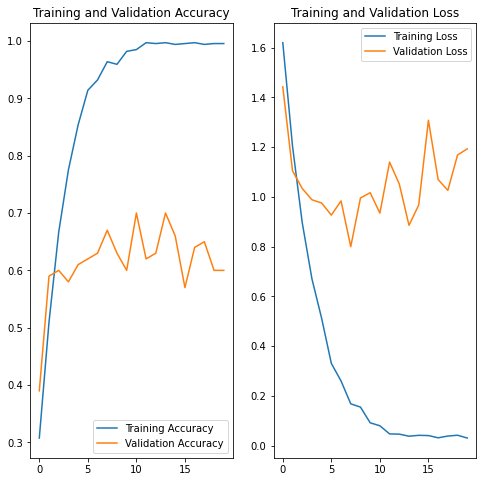

In [39]:
history = tl_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

print_accuracy_loss_values(tl_model,history,num_epochs)

### Inference :  Model 2 - Using  Mobilenet + GRU
- CNN with RNN (GRU - 128 cells)
     - Total Params: 3446725
     - categorical_loss:  0.0310
     - categorical_accuracy:  0.9955 
     - val_loss:  1.1930
     - val_categorical_accuracy:  0.6000 
     
     - Validation loss is very high. Model doesn't seem to learn with the architecture being used


## Conclusion 
### All models summaries


### Conv3D All models summaries

#### Conv3D Models
1. model 1 -test model

2. model 2- - Total params: 1866181
    - categorical_loss: 0.0902 
    - categorical_accuracy: 0.9970 
    - val_loss: 1.4247 
    - val_categorical_accuracy: 0.4500

3. model 3 - Total Params: 900805
     - categorical_loss: 0.3445 
     - categorical_accuracy: 0.8899 
     - val_loss: 0.6020 
     - val_categorical_accuracy: 0.8100 
     
4. model 4 - Total Params: 480,725
 - categorical_loss:  0.0879
 - categorical_accuracy:  0.9985
 - val_loss:  0.5717
 - val_categorical_accuracy:   0.8200 
     
5. model 5 -Total Params: 896,389
    - categorical_loss: 0.2692
    - categorical_accuracy: 0.9382
    - val_loss: 0.6012
    - val_categorical_accuracy: 0.8200
    
6. model 6 - Total Params: 1,131,589
     - categorical_loss:   0.3209 
     - categorical_accuracy:  0.8793
     - val_loss:  0.5026
     - val_categorical_accuracy: 0.8000 
     
7. model 7 - Total Params: 895477
    - categorical_loss:  0.8865  
     - categorical_accuracy:   0.6697
    - val_loss:  0.9613 
    - val_categorical_accuracy: 0.6900 
    
8. model 8 - Total Params: 985301
      - categorical_loss: loss: 0.3568  
      - categorical_accuracy:  0.9442 
      - val_loss:  0.7019
    - val_categorical_accuracy:  0.7100
    
9. model 9 - Total Params:  3710605
    - categorical_loss:   0.2617
    - categorical_accuracy:   0.9261 
     - val_loss:   0.5138
     - val_categorical_accuracy:  0.8100 
     
10. model 10 -  Total Params: 1961717
    - categorical_loss:  0.3390 
     - categorical_accuracy:   0.9050
     - val_loss:   0.4714
     - val_categorical_accuracy: : 0.8800
     
       
#### CNN + RNN Architecture
1. Model 1 CNN+RNN(LSTM - 64cells)
     - Total Params: 17,29,637
     - categorical_loss:  0.4255
     - categorical_accuracy:  0.8748
     - val_loss:  0.8886
     - val_categorical_accuracy:   0.6700
     
     
2. Model 2 CNN+RNN (GRU - 128 cells)
     - Total Params: 25,73,925
     - categorical_loss:  0.1371
     - categorical_accuracy:  0.9698
     - val_loss:  0.8177
     - val_categorical_accuracy:  0.7400 
       
### Transfer learning

1. Model 1 - Using  Mobilenet + LSTM - 128 cells
    - Total Params: 38,40,453
     - categorical_loss: 0.0201 
     - categorical_accuracy:  0.9985 
     - val_loss: 1.0242 
     - val_categorical_accuracy:  0.7000
     
    - Validation loss is very high. Model doesn't seem to learn with the architecture being used

2. Model 2 - Using  Mobilenet + GRU - 128 cells
     - Total Params: 
     - categorical_loss:  
     - categorical_accuracy:  
     - val_loss:  
     - val_categorical_accuracy:  
       

### Loading model and Testing

In [40]:
import time
from keras.models import load_model


In [ ]:
#model5
model = load_model('model_init_2024-01-2914_53_23.587929/model-00037-0.29820-0.91704-0.58179-0.83000.h5')

In [41]:
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

batch_size = 20  #experiment with the batch size
print ('# batch size =', batch_size)

frames_to_sample = 30
print ('# frames_to_sample per video =', frames_to_sample)

imageheight = 120
imagewidth = 120

# epochs = 40
# batch size = 20
# frames_to_sample per video = 30


In [ ]:
val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)
batch_data, batch_labels=next(val_generator)

NameError: name 'generator' is not defined

In [43]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [44]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))


[3 3 4 1 1 2 1 1 2 2 3 2 2 0 0 2 3 3 4 4]


In [45]:
#model 10
model = load_model('model_init_2024-01-3004_47_05.747776/model-00029-0.31665-0.90799-0.40022-0.90000.h5')

In [46]:
val_generator   = generator(val_path, val_doc, batch_size,frames_to_sample)
batch_data, batch_labels=next(val_generator)

Source path =  datasets/Project_data/val ; batch size = 20


In [47]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [48]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))


[2 3 1 1 1 1 3 2 3 4 4 3 0 4 1 0 3 1 4 1]
